In [4]:
%load_ext autoreload
# %load_ext memory_profiler
%autoreload 2
%matplotlib inline
from context import planvec

In [5]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage import measure, segmentation

from planvec import img_proc
from planvec.common import PROJECT_ROOT_PATH

In [6]:
ASSETS_DIR      = os.path.join(PROJECT_ROOT_PATH, 'test', 'assets')
INPUT_IMAGE     = 'greifer.png'
OUTPUT_PDF_NAME = 'sample_output.pdf'

input_img = planvec.io.read_img(ASSETS_DIR, INPUT_IMAGE)
img = img_proc.copy_img(input_img)  # Perform processing on image copy to keep original input unaltered

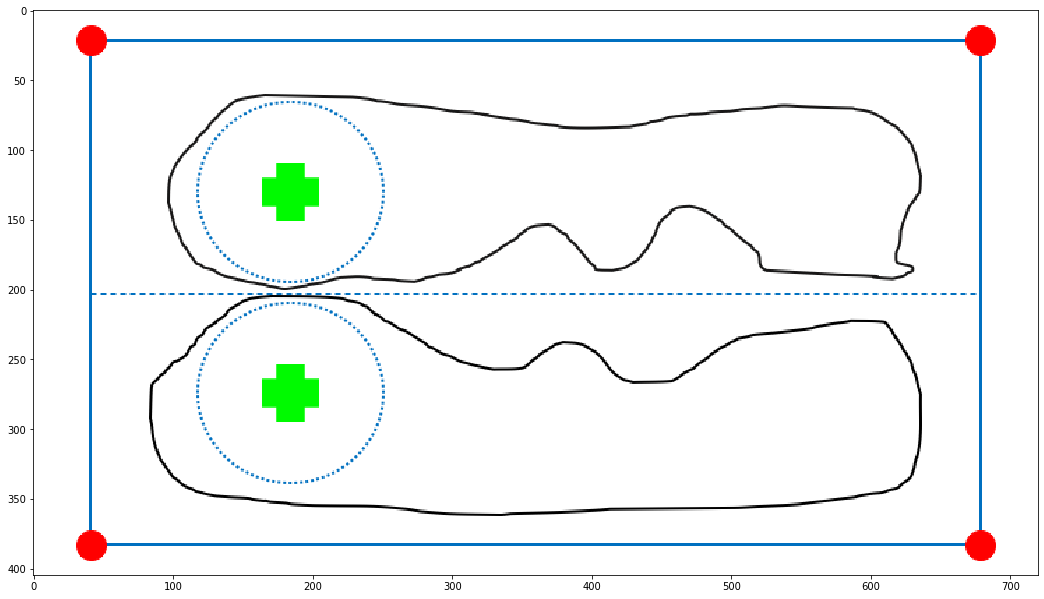

In [7]:
# Input image
planvec.vizualization.imshow(img, axis='on', figsize=(18,12))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


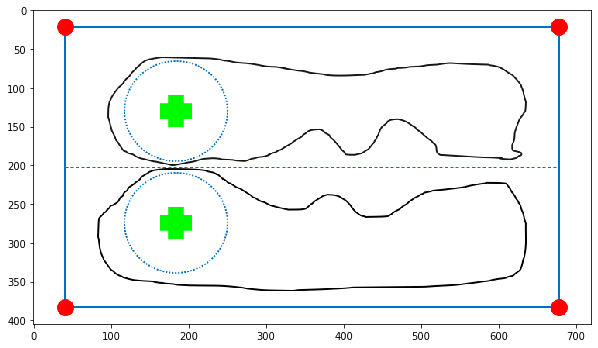

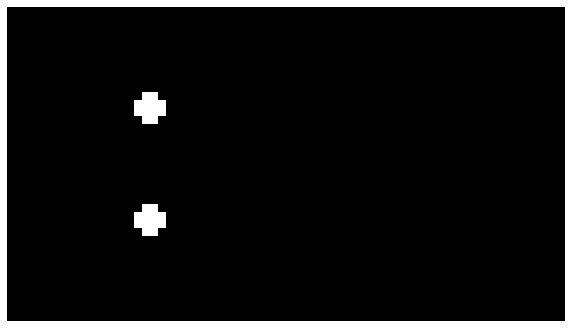

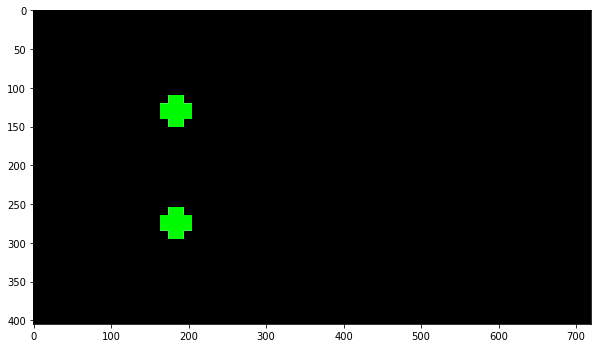

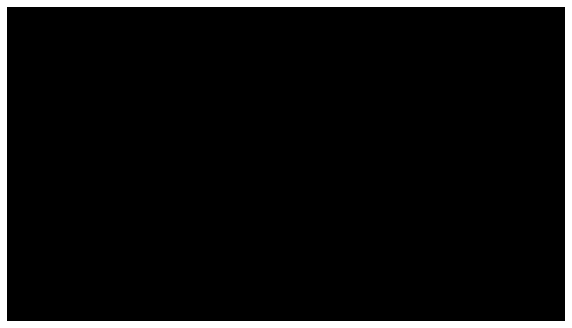

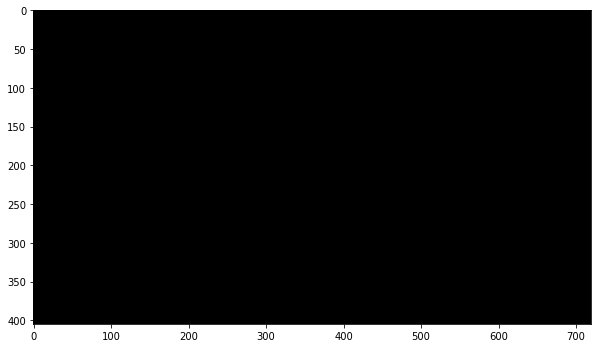

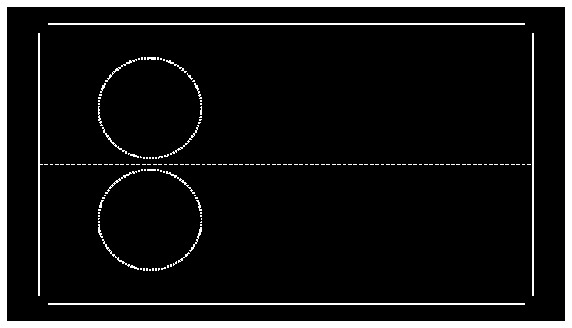

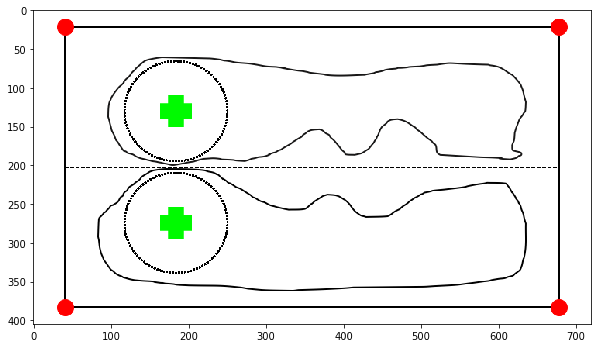

In [172]:
planvec.vizualization.imshow(img, axis='on', figsize=(10, 10))

img_blue = img_proc.filter_keep_by_hsv_range(img, [70,0,0], [160,255,255])
planvec.vizualization.imshow(img_blue, axis='on', figsize=(10,10))

img_blue = img_proc.filter_keep_multi_ranges(img, [[178,179,0], [255,255,255]], [[10,150,150], [179,150,150]])
planvec.vizualization.imshow(img_blue, axis='on', figsize=(10,10))

img_no_blue = img_proc.filter_out_by_hsv_range(img, [20,0,0], [40,255,255])
planvec.vizualization.imshow(img_no_blue, axis='on', figsize=(10, 10))

In [165]:
l = [np.array([1, 2, 3]), np.array([1, 2, 3])]
sum(l)

array([2, 4, 6])

In [11]:
"""
step 0 - filter out help lines (in green)
    - bounding box of the whole thing
    - circle around connection points
    - middle line
    
step 1 - filter for red edges and get 4 coordinates
    - HSV color filter

step 2 - warp image such that edge points are new edges
    - cv perspective transform

step 3 - do all the processing to find contours
    - ...

step 4 - put in connector holes in correct positions
    - place it by known position ratio w.r.t. edges
"""



'\nstep 0 - filter out help lines (in green)\n    - bounding box of the whole thing\n    - circle around connection points\n    - middle line\n    \nstep 1 - filter for red edges and get 4 coordinates\n    - HSV color filter\n\nstep 2 - warp image such that edge points are new edges\n    - cv perspective transform\n\nstep 3 - do all the processing to find contours\n    - ...\n\nstep 4 - put in connector holes in correct positions\n    - place it by known position ratio w.r.t. edges\n'

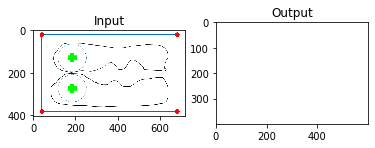

In [143]:
rows,cols,ch = img.shape
pts1 = np.float32([[41,30],[600,30],[50,400],[600,400]])
pts2 = np.float32([[0,0],[600,0],[400,0],[600,400]])
M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(600,400))
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [119]:
# Experimental!

#hsv_start = [0, 100, 50]
#hsv_end = [255, 255, 150]
#filtered_img = img_proc.filter_by_hsv_range(img, hsv_start, hsv_end)
#planvec.vizualization.imshow(filtered_img, figsize=(10,7), axis='off')

In [120]:
# Threshold processing
img = img_proc.img_to_greyscale(img)
img = img_proc.add_gaussian_blur(img, 5, 5)
img_thresh = img_proc.thresh_img(img, thresh_val=185, max_val=255, thresh_type=cv2.THRESH_BINARY)

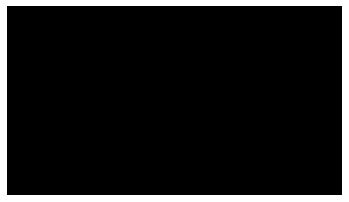

In [121]:
planvec.vizualization.imshow(img_thresh)

In [122]:
# Find and plots contours
#contours = img_proc.find_contours(img_thresh, 254)
#contours = img_proc.filter_contours_by_size(contours, n_points_thresh=1000)
#planvec.vizualization.plot_contours(contours, axis='on', figsize=(7, 10))

In [123]:
# Labelling connected regions
labelled_img, n = measure.label(img_thresh, background=0, return_num=True)
regions = measure.regionprops(labelled_img)

In [124]:
# Filtering regions
img_labelled_proc, filtered_regions = img_proc.filter_regions(labelled_img, regionprops=regions, area_threshold=50000)

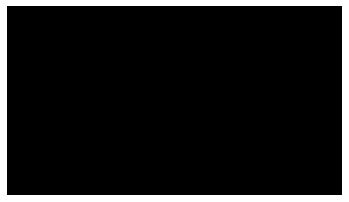

In [125]:
planvec.vizualization.imshow(img_labelled_proc)

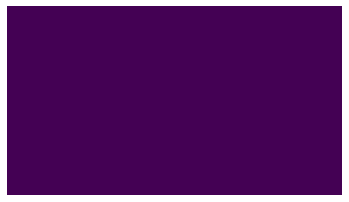

In [126]:
planvec.vizualization.plot_image_regions(img_labelled_proc, filtered_regions)

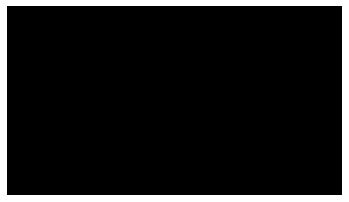

In [127]:
planvec.vizualization.imshow(img_labelled_proc!=0)

Contours left: 4


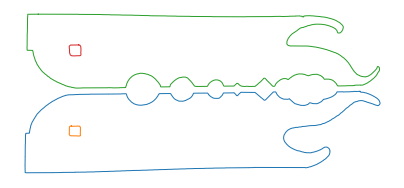

In [461]:
# Find contours of processed labelled image
contours = img_proc.find_contours(img_labelled_proc!=0, 0)
contours = img_proc.filter_contours_by_size(contours, n_points_thresh=100)
planvec.vizualization.plot_contours(contours, axis='off', figsize=(7, 10))
print(f'Contours left: {len(contours)}')

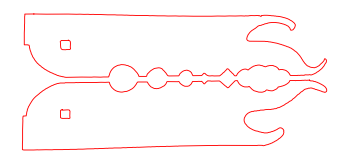

In [501]:
# Smooth contours by polygon approximation
approx_contours = []
for contour in contours:
    approx_contours.append(approximate_polygon(contour.copy(), tolerance=1))
output_fig = planvec.vizualization.plot_contours(approx_contours, axis='off', color='red', linewidth=0.9)

In [500]:
output_fig.savefig('output_lw005.pdf')

In [ ]:
# Stores the processed image to a PDF in the assets directory
# Deprecated
# img_proc.img_to_pdf(os.path.join(ASSETS_DIR, OUTPUT_PDF_NAME), img_thresh)

In [8]:
import cv2
import sys
import numpy as np

def nothing(x):
    pass

useCamera=False

# Check if filename is passed
if (len(sys.argv) <= 1) :
    print("'Usage: python hsvThresholder.py <ImageFilePath>' to ignore camera and use a local image.")
    useCamera = True

# Create a window
cv2.namedWindow('image')

# create trackbars for color change
cv2.createTrackbar('HMin','image',0,179,nothing) # Hue is from 0-179 for Opencv
cv2.createTrackbar('SMin','image',0,255,nothing)
cv2.createTrackbar('VMin','image',0,255,nothing)
cv2.createTrackbar('HMax','image',0,179,nothing)
cv2.createTrackbar('SMax','image',0,255,nothing)
cv2.createTrackbar('VMax','image',0,255,nothing)

# Set default value for MAX HSV trackbars.
cv2.setTrackbarPos('HMax', 'image', 179)
cv2.setTrackbarPos('SMax', 'image', 255)
cv2.setTrackbarPos('VMax', 'image', 255)

# Initialize to check if HSV min/max value changes
hMin = sMin = vMin = hMax = sMax = vMax = 0
phMin = psMin = pvMin = phMax = psMax = pvMax = 0

# Output Image to display
if useCamera:
    cap = cv2.VideoCapture(0)
    # Wait longer to prevent freeze for videos.
    waitTime = 330
else:
    img = img
    output = img
    waitTime = 33

while(1):

    if useCamera:
        # Capture frame-by-frame
        ret, img = cap.read()
        output = img

    # get current positions of all trackbars
    hMin = cv2.getTrackbarPos('HMin','image')
    sMin = cv2.getTrackbarPos('SMin','image')
    vMin = cv2.getTrackbarPos('VMin','image')

    hMax = cv2.getTrackbarPos('HMax','image')
    sMax = cv2.getTrackbarPos('SMax','image')
    vMax = cv2.getTrackbarPos('VMax','image')

    # Set minimum and max HSV values to display
    lower = np.array([hMin, sMin, vMin])
    upper = np.array([hMax, sMax, vMax])

    # Create HSV Image and threshold into a range.
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, lower, upper)
    output = cv2.bitwise_and(img,img, mask= mask)

    # Print if there is a change in HSV value
    if( (phMin != hMin) | (psMin != sMin) | (pvMin != vMin) | (phMax != hMax) | (psMax != sMax) | (pvMax != vMax) ):
        print("(hMin = %d , sMin = %d, vMin = %d), (hMax = %d , sMax = %d, vMax = %d)" % (hMin , sMin , vMin, hMax, sMax , vMax))
        phMin = hMin
        psMin = sMin
        pvMin = vMin
        phMax = hMax
        psMax = sMax
        pvMax = vMax

    # Display output image
    cv2.imshow('image',output)

    # Wait longer to prevent freeze for videos.
    if cv2.waitKey(waitTime) & 0xFF == ord('q'):
        break

# Release resources
if useCamera:
    cap.release()
cv2.destroyAllWindows()

(hMin = 0 , sMin = 0, vMin = 0), (hMax = 179 , sMax = 255, vMax = 255)


KeyboardInterrupt: 